# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger
from src.utils import PyTorchLightningPruningCallback
from src.train import main, objective, add_number, run_trial

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df()

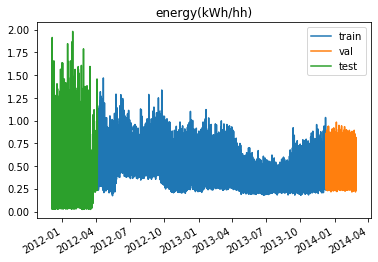

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_val['energy(kWh/hh)'].plot(label='val')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

# Default params

In [13]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0,
 'hidden_dim': 128,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2,
 'num_heads': 8,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'use_rnn': False,
}
default_attrs = {
    'context_in_target': True,
    'x_dim': 17,
     'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'max_nb_epochs': 200,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 16,
    'patience': 2
}

# Train ANP-RNN

now run `tensorboard --logdir lightning_logs`
trial.number -2
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 1 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._lstm_x                                                        

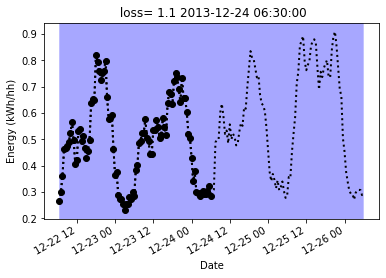

step val 0, {'val_loss': '1.0521490573883057', 'val/kl': '0.5039555430412292', 'val/std': '1.0264629125595093', 'val/mse': '0.29038164019584656'} {}


INFO:root:Detected KeyboardInterrupt, attempting graceful shutdown...



In [ ]:
trial, trainer, model = run_trial(
    name="anp-rnn",
    params={
     **default_params, 
     'det_enc_cross_attn_type': 'multihead',
     'det_enc_self_attn_type': 'uniform',
     'latent_enc_self_attn_type': 'uniform',
     'use_deterministic_path': True,
     'use_rnn': True
    },
    user_attrs = default_attrs,
    PL_MODEL_CLS=LatentModelPL
)

# ANP-RNN 2

In [ ]:
trial, trainer, model = run_trial(
    name="anp-rnn-nodt",
    params={
        **default_params, 
        'det_enc_cross_attn_type': 'ptmultihead',
        'det_enc_self_attn_type': 'uniform',
        'latent_enc_self_attn_type': 'uniform',
        'use_deterministic_path': False,
        'use_rnn': True
    },
    user_attrs=default_attrs,
    PL_MODEL_CLS=LatentModelPL)

# ANP

In [ ]:
trial, trainer, model = run_trial(name="anp",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'multihead',
                                      'latent_enc_self_attn_type': 'multihead',
                                      'use_deterministic_path': True,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

# NP

In [ ]:
trial, trainer, model = run_trial(name="np",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'uniform',
                                      'det_enc_self_attn_type': 'uniform',
                                      'latent_enc_self_attn_type': 'uniform',
                                      'use_deterministic_path': False,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

# Hyperparam

In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=20) if args.pruning else optuna.pruners.NopPruner()
pruner = optuna.pruners.PercentilePruner(75.0)
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


In [ ]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T